<span style="font-size: 20px;">**Setting**</span>

In [ ]:
# 필요한 라이브러리 임포트
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#print("PyTorch version:", torch.__version__)

# GPU 설정
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3,4,5"  # 2, 3, 4, 5번 GPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


<span style="font-size: 20px;">**Data Load**</span>

In [ ]:
# 데이터 경로 설정
data_dir = '/home/aix23107/GAN/longitudinal_data'  # MRI nii 파일 위치
label_file = '/home/aix23107/GAN/longitudinal_data/longitudinal.csv'  # 성별과 나이 정보가 있는 CSV 파일

# CSV 파일 확인
df = pd.read_csv(label_file)
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows of the dataset:")
print(df.head())
print("\nAge_2 distribution:")
print(df['Age_2'].describe())
print("\nAge_3 distribution:")
print(df['Age_3'].describe())
print("\nGender distribution:")
print(df['Sex'].value_counts())
print("\nAge Range:")
print(f"Minimum age: {df['Age_2'].min()}")
print(f"Maximum age: {df['Age_3'].max()}")



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3854 entries, 0 to 3853
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      3854 non-null   int64  
 1   Sex     3854 non-null   int64  
 2   Age_2   3854 non-null   int64  
 3   Age_3   3854 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 120.6 KB
None

First few rows of the dataset:
        ID  Sex  Age_2  Age_3
0  1000248    0     57   63.0
1  1000757    0     59   61.0
2  1002051    1     77   80.0
3  1002926    0     67   69.0
4  1002940    0     76   78.0

Age_2 distribution:
count    3854.000000
mean       61.379865
std         7.451720
min        46.000000
25%        55.000000
50%        61.000000
75%        67.000000
max        80.000000
Name: Age_2, dtype: float64

Age_3 distribution:
count    3854.000000
mean       64.029839
std         7.237142
min        49.000000
25%        58.000000
50%        64.000000
75%        70.000000
max

<span style="font-size: 20px;">**Dataset**</span>

In [4]:
import os
import torch
import nibabel as nib
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split

class MRI_Slice_Dataset(Dataset):
   def __init__(self, data_dir, df, desired_shape=(160, 208), transform=None):
       """
       Args:
           data_dir (str): MRI 이미지가 저장된 디렉토리
           df (pd.DataFrame): 성별과 나이 정보가 포함된 DataFrame
           desired_shape (tuple): 슬라이스 리사이즈 목표 크기 (height, width)
           transform (callable, optional): 데이터에 적용할 변환 함수
       """
       self.data_dir = data_dir
       self.df = df
       self.desired_shape = desired_shape
       self.transform = transform

       # 유효한 데이터셋만 유지하기 위해 ID 쌍 확인
       self.df = self.df[self.df['ID'].apply(self._check_pair_exists)].reset_index(drop=True)
       
   def _check_pair_exists(self, img_id):
       """ID를 기준으로 {ID}_0.nii, {ID}_1.nii 파일 쌍이 모두 존재하는지 확인"""
       img_id = str(int(img_id))  # 정수형으로 변환하여 파일명 확인
       t0_path = os.path.join(self.data_dir, f"{img_id}_0.nii")
       t1_path = os.path.join(self.data_dir, f"{img_id}_1.nii")
       return os.path.exists(t0_path) and os.path.exists(t1_path)
       
   def __len__(self):
       return len(self.df)
   
   def normalize_slice(self, slice_2d):
       """슬라이스 정규화"""
       slice_2d = slice_2d.astype(np.float32)  # dtype 설정
       mean = float(slice_2d.mean())
       std = float(slice_2d.std())
       slice_2d = (slice_2d - mean) / std
       slice_2d = np.clip(slice_2d, -3, 3)
       slice_2d = (slice_2d + 3) / 6
       slice_2d = slice_2d * 2 - 1
       return slice_2d
   
   def load_and_process_mri(self, file_path):
       """MRI 파일 로드 및 전처리"""
       mri = nib.load(file_path).get_fdata()
       slice_idx = mri.shape[2] // 2
       slice_2d = mri[:, :, slice_idx]
       
       # 크기 조정
       zoom_factors = (self.desired_shape[0] / slice_2d.shape[0],
                      self.desired_shape[1] / slice_2d.shape[1])
       slice_2d = zoom(slice_2d, zoom_factors)
       slice_2d = self.normalize_slice(slice_2d)
       
       # 텐서 변환
       return torch.tensor(slice_2d, dtype=torch.float32).unsqueeze(0)  # (1, H, W)
   
   def __getitem__(self, idx):
       # 현재 데이터 로드
       img_id = str(int(self.df.iloc[idx]['ID']))  # 정수형으로 변환하여 파일명 구성
       
       # t0, t1 시점의 MRI 파일 로드 및 처리
       t0_path = os.path.join(self.data_dir, f"{img_id}_0.nii")
       t1_path = os.path.join(self.data_dir, f"{img_id}_1.nii")
       
       t0_tensor = self.load_and_process_mri(t0_path)
       t1_tensor = self.load_and_process_mri(t1_path)
       
       # 현재 나이와 성별
       current_age = self.df.iloc[idx]['Age_2']
       gender = self.df.iloc[idx]['Sex']  # 0: 여자, 1: 남자
       
       # 타겟 나이 설정 (나이 범위 46~82 제한)
       target_age = min(max(self.df.iloc[idx]['Age_3'], 46), 82)
       
       # conditions 텐서 생성 (나이와 성별)
       conditions = torch.tensor([current_age, gender], dtype=torch.float32)
       
       # age_gap 계산 및 텐서 생성
       age_gap = torch.tensor([target_age - current_age], dtype=torch.float32)
       
       return t0_tensor, t1_tensor, conditions, age_gap

<span style="font-size: 20px;">**Data Split**</span>

In [5]:

# 나이 차이에 따른 그룹화
group_1_3 = df[df['Age_3'] - df['Age_2'] <= 3]
group_4_8 = df[df['Age_3'] - df['Age_2'] > 3]

# 1~3년 차이 그룹에서 80:20 비율로 분할
train_1_3, test_1_3 = train_test_split(group_1_3, test_size=0.2, random_state=42)

# 4~8년 차이 그룹에서 90:10 비율로 분할
train_4_8, test_4_8 = train_test_split(group_4_8, test_size=0.1, random_state=42)

# 훈련 및 테스트 데이터프레임 결합
train_df = pd.concat([train_1_3, train_4_8]).reset_index(drop=True)
test_df = pd.concat([test_1_3, test_4_8]).reset_index(drop=True)

# 훈련 데이터셋 및 테스트 데이터셋 생성
train_dataset = MRI_Slice_Dataset(data_dir, train_df, desired_shape=(160, 208))
test_dataset = MRI_Slice_Dataset(data_dir, test_df, desired_shape=(160, 208))

# 데이터로더 설정 (보완된 설정 적용)
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=True,
    num_workers=4,  # 병렬 처리
    pin_memory=True  # GPU 사용 시 성능 향상
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=8, 
    shuffle=False,
    num_workers=4,  # 병렬 처리
    pin_memory=True  # GPU 사용 시 성능 향상
)

<span style="font-size: 20px;">**Visualization**</span>

t0 시점 이미지 shape: torch.Size([8, 1, 160, 208])
t1 시점 이미지 shape: torch.Size([8, 1, 160, 208])


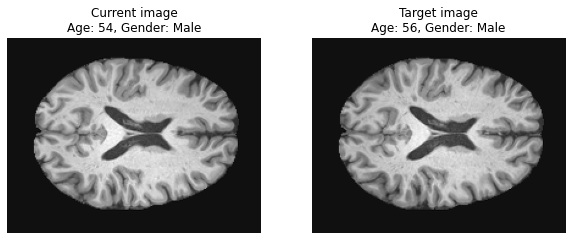

In [6]:
import matplotlib.pyplot as plt

# train_dataloader에서 샘플 데이터 하나 가져오기
sample = next(iter(train_dataloader))
t0_image, t1_image, conditions, age_gap = sample

# t0 시점과 t1 시점 이미지의 shape 출력
print("t0 시점 이미지 shape:", t0_image.shape)  # (batch_size, channels, height, width)
print("t1 시점 이미지 shape:", t1_image.shape)

# 배치의 첫 번째 샘플만 시각화
t0_sample = t0_image[0].squeeze().cpu().numpy()  # (H, W) 형태로 변환
t1_sample = t1_image[0].squeeze().cpu().numpy()

# 첫 번째 샘플의 조건 정보 (나이와 성별)
current_age, gender = conditions[0][0].item(), int(conditions[0][1].item())
target_age = current_age + age_gap[0][0].item()

# 성별 텍스트 설정
gender_text = "Female" if gender == 0 else "Male"

# 시각화
plt.figure(figsize=(10, 5))

# t0 시점 이미지 시각화
plt.subplot(1, 2, 1)
plt.imshow(t0_sample, cmap="gray")
plt.title(f"Current image\nAge: {int(current_age)}, Gender: {gender_text}")
plt.axis("off")

# t1 시점 이미지 시각화
plt.subplot(1, 2, 2)
plt.imshow(t1_sample, cmap="gray")
plt.title(f"Target image\nAge: {int(target_age)}, Gender: {gender_text}")
plt.axis("off")

plt.show()


<span style="font-size: 20px;">**Model**</span>

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        
        q = self.query(x).view(batch_size, -1, height * width)
        k = self.key(x).view(batch_size, -1, height * width)
        v = self.value(x).view(batch_size, -1, height * width)
        
        attention = F.softmax(torch.bmm(q.permute(0, 2, 1), k), dim=2)
        out = torch.bmm(v, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)
        
        return self.gamma * out + x

class ResNetBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResNetBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, 3, padding=1),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        return F.relu(x + self.block(x))

class ConditionEncoder(nn.Module):
    def __init__(self):
        super(ConditionEncoder, self).__init__()
        # 현재 나이 임베딩 (46-82 범위)
        self.age_encoder = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )
        
        # 성별 임베딩 (0: 여성, 1: 남성)
        self.sex_encoder = nn.Sequential(
            nn.Embedding(2, 64),
            nn.Linear(64, 128)
        )
        
        # age_gap 임베딩 (1-8년 범위)
        self.age_gap_encoder = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )
        
        # 결합된 특징을 처리하는 층
        self.combine = nn.Sequential(
            nn.Linear(384, 256),  # 128 * 3 = 384
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, age, sex, age_gap):
        # 각 조건을 개별적으로 인코딩
        age_embed = self.age_encoder(age.unsqueeze(1))
        sex_embed = self.sex_encoder(sex)
        age_gap_embed = self.age_gap_encoder(age_gap.unsqueeze(1))
        
        # 모든 임베딩 결합
        combined = torch.cat([age_embed, sex_embed, age_gap_embed], dim=1)
        return self.combine(combined)

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        
        # t0 이미지 인코더 - skip connection을 위한 중간 특징 저장
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2)
        )
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        
        # 조건 임베딩
        self.condition_embedding = nn.Sequential(
            nn.Linear(3, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128)
        )
        
        # 초기 프로젝션
        self.initial = nn.Sequential(
            nn.Linear(latent_dim + 128, 512 * 10 * 13),
            nn.LeakyReLU(0.2)
        )
        
        # 디코더 (U-Net 스타일의 skip connection 추가)
        self.decoder_conv1 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        
        self.decoder_conv2 = nn.Sequential(
            nn.Conv2d(512 + 256, 256, 3, 1, 1),  # skip connection
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        
        self.decoder_conv3 = nn.Sequential(
            nn.Conv2d(256 + 128, 128, 3, 1, 1),  # skip connection
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        
        self.decoder_conv4 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, 3, 1, 1),  # skip connection
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 1, 1),
            nn.Tanh()
        )
        
    def forward(self, x_t0, z, conditions, age_gap):
        # 인코더 - 중간 특징 저장
        e1 = self.enc1(x_t0)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        
        # 조건 처리
        current_age = conditions[:, 0]
        sex = conditions[:, 1].long()
        age_gap = age_gap.squeeze(-1) if age_gap.dim() > 1 else age_gap
        
        conditions = torch.cat([
            current_age.unsqueeze(1),
            sex.float().unsqueeze(1),
            age_gap.unsqueeze(1)
        ], dim=1)
        
        condition_embedding = self.condition_embedding(conditions)
        
        # 잠재 벡터와 조건 결합
        x = torch.cat([z, condition_embedding], 1)
        x = self.initial(x)
        x = x.view(-1, 512, 10, 13)
        
        # t0 특징과 결합
        x = torch.cat([x, e4], 1)
        
        # 디코더 (skip connections 사용)
        x = self.decoder_conv1(x)
        x = F.interpolate(x, size=(20, 26), mode='bilinear', align_corners=True)
        x = torch.cat([x, e3], 1)
        
        x = self.decoder_conv2(x)
        x = F.interpolate(x, size=(40, 52), mode='bilinear', align_corners=True)
        x = torch.cat([x, e2], 1)
        
        x = self.decoder_conv3(x)
        x = F.interpolate(x, size=(80, 104), mode='bilinear', align_corners=True)
        x = torch.cat([x, e1], 1)
        
        x = self.decoder_conv4(x)
        x = F.interpolate(x, size=(160, 208), mode='bilinear', align_corners=True)
        
        return self.final_conv(x)

       

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Condition Encoder
        self.condition_encoder = ConditionEncoder()
        
        # t0 이미지 인코더
        self.t0_encoder = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),      # (1, 160, 208) -> (64, 80, 104)
            nn.LeakyReLU(0.2),
            ResNetBlock(64),
            
            nn.Conv2d(64, 128, 4, 2, 1),    # (64, 80, 104) -> (128, 40, 52)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            ResNetBlock(128),
            
            nn.Conv2d(128, 256, 4, 2, 1),   # (128, 40, 52) -> (256, 20, 26)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            ResNetBlock(256),
            
            nn.Conv2d(256, 512, 4, 2, 1),   # (256, 20, 26) -> (512, 10, 13)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        
        # 조건을 공간적 특징으로 변환
        self.condition_to_spatial = nn.Sequential(
            nn.Linear(128, 512 * 10 * 13),
            nn.LeakyReLU(0.2)
        )
        
        # 메인 판별기
        self.main = nn.Sequential(
            # (1024, 10, 13) [t0_features(512) + condition_spatial(512)]
            nn.Conv2d(1024, 512, 3, 1, 1),
            nn.LeakyReLU(0.2),
            ResNetBlock(512),
            SelfAttention(512),
            
            nn.Conv2d(512, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            ResNetBlock(256)
        )
        
        # 최종 판별층
        self.final = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 10 * 13, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x_t1, x_t0, conditions, age_gap):
        # 조건 처리
        current_age = conditions[:, 0]
        sex = conditions[:, 1].long()
        age_gap = age_gap.squeeze(-1) if age_gap.dim() > 1 else age_gap
        
        # 조건 인코딩
        condition_embedding = self.condition_encoder(current_age, sex, age_gap)
        
        # 조건을 공간적 특징으로 변환
        condition_spatial = self.condition_to_spatial(condition_embedding)
        condition_spatial = condition_spatial.view(-1, 512, 10, 13)
        
        # t0 이미지와 x_t1 처리
        t0_features = self.t0_encoder(x_t0)     # -> (512, 10, 13)
        x_t1_features = self.t0_encoder(x_t1)   # -> (512, 10, 13)
        
        # 특징 결합
        combined_features = torch.cat([x_t1_features, condition_spatial], 1)
        
        # 판별
        x = self.main(combined_features)
        return self.final(x)

In [8]:
import torch
import torch.nn as nn

def test_model_layers():
    print("=== Starting Layer-by-Layer Test ===\n")
    
    # 장치 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}\n")
    
    # 모델 초기화
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    
    # 테스트 입력 생성
    batch_size = 4
    latent_dim = 100
    image_shape = (1, 160, 208)  # Single channel image with (160, 208)
    
    # t0 이미지 입력, 잠재 벡터 및 조건 생성
    test_t0_image = torch.randn(batch_size, *image_shape).to(device)
    test_latent = torch.randn(batch_size, latent_dim).to(device)
    test_condition = torch.tensor([
        [65.0, 1.0],
        [45.0, 0.0],
        [55.0, 1.0],
        [75.0, 0.0]
    ]).to(device)
    test_age_gap = torch.tensor([[5.0], [10.0], [15.0], [20.0]]).to(device)

    print("Testing Generator...")
    try:
        # Generator 입력 확인
        print("\nGenerator Input Shapes:")
        print(f"t0 Image: {test_t0_image.shape}")
        print(f"Latent vector: {test_latent.shape}")
        print(f"Condition: {test_condition.shape}")
        print(f"Age gap: {test_age_gap.shape}")
        
        # Generator 실행
        print("\nGenerator Forward Pass:")
        generated_images = generator(test_t0_image, test_latent, test_condition, test_age_gap)
        print(f"\nFinal Generator Output Shape: {generated_images.shape}")
        
    except Exception as e:
        print(f"Generator test failed with error: {str(e)}")
        import traceback
        traceback.print_exc()
    
    print("\nTesting Discriminator...")
    try:
        # Discriminator 입력 확인
        print("\nDiscriminator Input Shapes:")
        print(f"t1 Image (Generated): {generated_images.shape}")
        print(f"t0 Image: {test_t0_image.shape}")
        print(f"Condition: {test_condition.shape}")
        print(f"Age gap: {test_age_gap.shape}")
        
        # Discriminator 실행
        discriminator_output = discriminator(generated_images, test_t0_image, test_condition, test_age_gap)
        print(f"\nFinal Discriminator Output Shape: {discriminator_output.shape}")
        
    except Exception as e:
        print(f"Discriminator test failed with error: {str(e)}")
        import traceback
        traceback.print_exc()
    
    print("\n=== Test Complete ===")

# 테스트 실행
if __name__ == "__main__":
    test_model_layers()


=== Starting Layer-by-Layer Test ===

Using device: cuda

Testing Generator...

Generator Input Shapes:
t0 Image: torch.Size([4, 1, 160, 208])
Latent vector: torch.Size([4, 100])
Condition: torch.Size([4, 2])
Age gap: torch.Size([4, 1])

Generator Forward Pass:

Final Generator Output Shape: torch.Size([4, 1, 160, 208])

Testing Discriminator...

Discriminator Input Shapes:
t1 Image (Generated): torch.Size([4, 1, 160, 208])
t0 Image: torch.Size([4, 1, 160, 208])
Condition: torch.Size([4, 2])
Age gap: torch.Size([4, 1])

Final Discriminator Output Shape: torch.Size([4, 1])

=== Test Complete ===


<span style="font-size: 20px;">**Loss Function**</span>

In [9]:
class BrainAgingLoss:
    def __init__(self, lambda_l1=10, lambda_identity=2):
        self.l1_lambda = lambda_l1          # 이미지 품질을 위한 가중치
        self.identity_lambda = lambda_identity  # 변화량 학습을 위한 가중치
        self.adversarial_loss = nn.BCELoss()
        self.l1_loss = nn.L1Loss()
        
    def generator_loss(self, fake_output, real_t1, generated_t1, t0_image, age_gap):
        # 1. Adversarial Loss (GAN의 기본 Loss)
        real_target = torch.ones_like(fake_output)
        gan_loss = self.adversarial_loss(fake_output, real_target)
        
        # 2. L1 Loss (생성된 이미지와 실제 t1 이미지의 차이)
        l1_loss = self.l1_loss(generated_t1, real_t1)
        
        # 3. Progressive Loss (시간에 따른 변화량 학습)
        # age_gap에 따른 가중치 계산 (1-8년 범위 고려하여 2.0으로 스케일링)
        progressive_weight = torch.sigmoid(age_gap / 2.0)
        # 실제 변화량과 생성된 변화량 비교
        progression_loss = self.l1_loss(generated_t1 - t0_image, real_t1 - t0_image)
        
        # 최종 Generator Loss
        total_loss = gan_loss + \
                    self.l1_lambda * l1_loss + \
                    self.identity_lambda * (progressive_weight * progression_loss).mean()
                    
        return total_loss, {
            'G_gan': gan_loss.item(),
            'G_l1': l1_loss.item(),
            'G_prog': progression_loss.item()
        }
    
    def discriminator_loss(self, real_output, fake_output):
        # Real/Fake 이미지 판별 Loss
        real_target = torch.ones_like(real_output)
        fake_target = torch.zeros_like(fake_output)
        
        real_loss = self.adversarial_loss(real_output, real_target)
        fake_loss = self.adversarial_loss(fake_output, fake_target)
        
        total_loss = (real_loss + fake_loss) * 0.5
        
        return total_loss, {
            'D_real': real_loss.item(),
            'D_fake': fake_loss.item()
        }

In [10]:
import torch
import torch.nn as nn

# 가상의 데이터 생성
def generate_fake_data(batch_size=4, img_shape=(1, 160, 208), latent_dim=100):
    # t0 시점의 이미지 (실제 이미지)
    t0_image = torch.randn(batch_size, *img_shape)
    
    # t1 시점의 실제 이미지 (목표로 하는 이미지)
    real_t1 = torch.randn(batch_size, *img_shape)
    
    # t1 시점의 생성된 이미지 (Generator가 생성한 가짜 이미지)
    generated_t1 = torch.randn(batch_size, *img_shape)
    
    # Discriminator가 판단한 가짜 이미지에 대한 출력
    fake_output = torch.sigmoid(torch.randn(batch_size, 1))  # [0, 1] 범위로 조정
    
    # Discriminator가 판단한 실제 이미지에 대한 출력
    real_output = torch.sigmoid(torch.randn(batch_size, 1))
    
    # 조건 정보와 age_gap
    conditions = torch.tensor([
        [65.0, 1.0],
        [45.0, 0.0],
        [55.0, 1.0],
        [75.0, 0.0]
    ])
    age_gap = torch.tensor([[5.0], [10.0], [15.0], [20.0]])
    
    return t0_image, real_t1, generated_t1, fake_output, real_output, conditions, age_gap

# 손실 함수 테스트 함수
def test_loss_functions():
    # 손실 클래스 초기화
    brain_aging_loss = BrainAgingLoss(lambda_l1=10, lambda_identity=2)
    
    # 가상의 데이터 생성
    t0_image, real_t1, generated_t1, fake_output, real_output, conditions, age_gap = generate_fake_data()
    
    # Generator Loss 테스트
    print("=== Testing Generator Loss ===")
    gen_loss, gen_loss_components = brain_aging_loss.generator_loss(
        fake_output, real_t1, generated_t1, t0_image, age_gap
    )
    print("Generator Total Loss:", gen_loss.item())
    for key, value in gen_loss_components.items():
        print(f"{key}: {value}")
    
    # Discriminator Loss 테스트
    print("\n=== Testing Discriminator Loss ===")
    disc_loss, disc_loss_components = brain_aging_loss.discriminator_loss(
        real_output, fake_output
    )
    print("Discriminator Total Loss:", disc_loss.item())
    for key, value in disc_loss_components.items():
        print(f"{key}: {value}")

# 테스트 실행
if __name__ == "__main__":
    test_loss_functions()


=== Testing Generator Loss ===
Generator Total Loss: 14.129293441772461
G_gan: 0.6197715997695923
G_l1: 1.1297074556350708
G_prog: 1.1297074556350708

=== Testing Discriminator Loss ===
Discriminator Total Loss: 1.0088279247283936
D_real: 1.0739572048187256
D_fake: 0.943698525428772


<span style="font-size: 20px;">**Training**</span>

In [11]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import os

def show_image_grid(images, title, nrow=4, cmap=None, vmin=None, vmax=None):
    images = images.cpu()
    grid = make_grid(images, nrow=nrow, normalize=True, range=(-1, 1))
    if cmap:
        plt.imshow(grid.permute(1, 2, 0).mean(dim=2).detach().numpy(), cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        plt.imshow(grid.permute(1, 2, 0).detach().numpy())
    plt.title(title)
    plt.axis('off')

def train_model(generator, discriminator, train_loader, num_epochs=30, lr=0.0001, lambda_l1=50, lambda_identity=5, device='cuda'):
    # 멀티 GPU 설정
    num_gpus = torch.cuda.device_count()
    if num_gpus > 1:
        print(f"Using {num_gpus} GPUs for training.")
        generator = torch.nn.DataParallel(generator)
        discriminator = torch.nn.DataParallel(discriminator)
    else:
        print("Using a single GPU for training.")

    # 모델을 장치로 이동
    generator.to(device)
    discriminator.to(device)
    
    # 옵티마이저 설정
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr*0.5, betas=(0.5, 0.999))
    
    # 스케줄러 설정
    scheduler_G = optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, mode='min', factor=0.5, patience=5, verbose=True)
    scheduler_D = optim.lr_scheduler.ReduceLROnPlateau(optimizer_D, mode='min', factor=0.5, patience=5, verbose=True)
    
    # 손실 함수
    brain_aging_loss = BrainAgingLoss(lambda_l1=lambda_l1, lambda_identity=lambda_identity)
    
    # Best model 초기화
    best_g_loss = float('inf')
    
    # 결과 저장 디렉토리 생성
    os.makedirs('checkpoints', exist_ok=True)
    os.makedirs('training_progress', exist_ok=True)
    
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        
        # tqdm 학습 상태 표시
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
            for i, (t0_image, t1_image, conditions, age_gap) in enumerate(train_loader):
                # 데이터 장치로 이동
                t0_image, t1_image = t0_image.to(device), t1_image.to(device)
                conditions, age_gap = conditions.to(device), age_gap.to(device)
                
                batch_size = t0_image.size(0)
                
                # ------------------
                # Train Discriminator
                # ------------------
                current_d_loss = epoch_d_loss/(i+1) if i > 0 else 1.0
                
                if current_d_loss > 0.6:  # D가 너무 약하지 않을 때만 학습
                    optimizer_D.zero_grad()
                    
                    # 진짜 이미지 판별
                    real_output = discriminator(t1_image, t0_image, conditions, age_gap)
                    
                    # 가짜 이미지 생성 및 판별
                    z = torch.randn(batch_size, 100, device=device)
                    generated_t1 = generator(t0_image, z, conditions, age_gap)
                    fake_output = discriminator(generated_t1.detach(), t0_image, conditions, age_gap)
                    
                    # Discriminator Loss 계산 및 업데이트
                    d_loss, d_loss_components = brain_aging_loss.discriminator_loss(real_output, fake_output)
                    d_loss.backward()
                    optimizer_D.step()
                    d_loss = d_loss.item()
                else:
                    d_loss = epoch_d_loss/max(1, i)
                
                # ------------------
                # Train Generator
                # ------------------
                # D가 너무 강할 때는 G를 더 자주 학습
                n_critic = 2 if current_d_loss < 0.6 else 1
                
                g_loss_sum = 0
                for _ in range(n_critic):
                    optimizer_G.zero_grad()
                    
                    # 가짜 이미지 생성
                    z = torch.randn(batch_size, 100, device=device)
                    generated_t1 = generator(t0_image, z, conditions, age_gap)
                    
                    # 생성된 가짜 이미지로 Generator 손실 계산
                    fake_output = discriminator(generated_t1, t0_image, conditions, age_gap)
                    g_loss, g_loss_components = brain_aging_loss.generator_loss(fake_output, t1_image, generated_t1, t0_image, age_gap)
                    g_loss.backward()
                    optimizer_G.step()
                    g_loss_sum += g_loss.item()
                
                g_loss = g_loss_sum / n_critic
                
                # 손실 값 기록
                epoch_d_loss += d_loss
                epoch_g_loss += g_loss
                
                # tqdm 상태 업데이트
                pbar.set_postfix({
                    'D Loss': f"{epoch_d_loss/(i+1):.4f}",
                    'G Loss': f"{epoch_g_loss/(i+1):.4f}",
                    'G_gan': f"{g_loss_components['G_gan']:.4f}",
                    'G_l1': f"{g_loss_components['G_l1']:.4f}",
                    'G_prog': f"{g_loss_components['G_prog']:.4f}",
                    'n_critic': n_critic
                })
                pbar.update(1)
        
        # 에폭 평균 손실 계산
        avg_g_loss = epoch_g_loss / len(train_loader)
        avg_d_loss = epoch_d_loss / len(train_loader)
        
        # 평균 손실 출력
        print(f"\nEpoch {epoch + 1} - Average G_loss: {avg_g_loss:.4f}, Average D_loss: {avg_d_loss:.4f}")

        # 스케줄러 업데이트
        scheduler_G.step(avg_g_loss)
        scheduler_D.step(avg_d_loss)
        
        # Best model 저장
        if avg_g_loss < best_g_loss:
            best_g_loss = avg_g_loss
            print(f"\nSaving best model with loss: {best_g_loss:.4f}")
            torch.save({
                'epoch': epoch + 1,
                'generator_state_dict': generator.module.state_dict() if num_gpus > 1 else generator.state_dict(),
                'discriminator_state_dict': discriminator.module.state_dict() if num_gpus > 1 else discriminator.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
                'best_g_loss': best_g_loss
            }, 'checkpoints/best_model_v2.pt')
        
        # 주기적인 체크포인트 저장
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch + 1,
                'generator_state_dict': generator.module.state_dict() if num_gpus > 1 else generator.state_dict(),
                'discriminator_state_dict': discriminator.module.state_dict() if num_gpus > 1 else discriminator.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
            }, f'checkpoints/checkpoint_epoch_{epoch + 1}.pt')
        
        # 결과 시각화
        generator.eval()
        with torch.no_grad():
            # 배치의 첫 번째 샘플만 사용
            t0_sample = t0_image[:4]
            t1_sample = t1_image[:4]
            conditions_sample = conditions[:4]
            age_gap_sample = age_gap[:4]
            z_sample = torch.randn(4, 100, device=device)
            generated_sample = generator(t0_sample, z_sample, conditions_sample, age_gap_sample)
            
            # 실제 샘플 수 확인
            num_samples = min(4, t0_sample.size(0))

            fig, axes = plt.subplots(4, num_samples, figsize=(15, 16))
            for i in range(num_samples):
                young_age, young_sex = conditions_sample[i, 0].item(), "F" if conditions_sample[i, 1] == 0 else "M"
                target_age = young_age + age_gap_sample[i].item()

                axes[0, i].imshow(t0_sample[i, 0].cpu(), cmap='gray')
                axes[0, i].axis('off')
                axes[0, i].set_title(f'Age: {young_age:.0f} | Sex: {young_sex}')
                
                axes[1, i].imshow(t1_sample[i, 0].cpu(), cmap='gray')
                axes[1, i].axis('off')
                axes[1, i].set_title(f'Target Age: {target_age:.0f}')
                
                axes[2, i].imshow(generated_sample[i, 0].cpu(), cmap='gray')
                axes[2, i].axis('off')
                axes[2, i].set_title(f'Generated Age: {target_age:.0f}')
                
                diff_map = (generated_sample[i] - t0_sample[i]).abs().cpu().numpy()
                axes[3, i].imshow(diff_map[0], cmap='bwr', vmin=-1, vmax=1)
                axes[3, i].axis('off')
                axes[3, i].set_title('Difference Map')

            plt.suptitle(f'Epoch {epoch + 1} - Original, Target, Generated, and Difference Maps')
            plt.tight_layout()
            plt.show()
            plt.close()

if __name__ == "__main__":
    # Device 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # 모델 초기화
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    
    # 데이터로더는 이전에 정의한 것을 사용
    train_model(
        generator=generator,
        discriminator=discriminator,
        train_loader=train_dataloader,
        num_epochs=30,
        lr=0.0001,
        lambda_l1=50,
        lambda_identity=5,
        device=device
    )

Using device: cuda
Using 4 GPUs for training.


Epoch 1/30:   0%|          | 0/392 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [12]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

<span style="font-size: 20px;">**Metrics**</span>

In [13]:
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import os
import matplotlib.pyplot as plt


def calculate_metrics(img1, img2):
    """두 이미지 간의 품질 메트릭 계산"""
    img1 = img1.cpu().numpy().squeeze()
    img2 = img2.cpu().numpy().squeeze()

    # -1~1 범위를 0~1로 변환
    img1 = (img1 + 1) / 2
    img2 = (img2 + 1) / 2

    # 메트릭 계산
    mae = np.mean(np.abs(img1 - img2))
    mse = np.mean((img1 - img2) ** 2)
    psnr_value = psnr(img2, img1, data_range=1)
    ssim_value = ssim(img2, img1, data_range=1)

    return {
        'MAE': mae,
        'MSE': mse,
        'PSNR': psnr_value,
        'SSIM': ssim_value
    }


def test_model(generator, test_loader, device, save_dir='test_results'):
    """Baseline vs. Generated, Baseline vs. Ground Truth 품질 평가"""
    os.makedirs(save_dir, exist_ok=True)
    generator.eval()

    # 전체 메트릭 저장
    baseline_generated_metrics_list = []
    baseline_groundtruth_metrics_list = []
    generated_groundtruth_metrics_list = []

    with torch.no_grad():
        for i, (t0_image, t1_image, conditions, age_gap) in enumerate(test_loader):
            # 데이터 준비
            t0_image = t0_image.to(device)
            t1_image = t1_image.to(device)
            conditions = conditions.to(device)
            age_gap = age_gap.to(device)  # age_gap도 device로 이동해야 함

            # 이미지 생성 (age_gap 포함)
            z = torch.randn(t0_image.size(0), 100, device=device)
            generated_images = generator(t0_image, z, conditions, age_gap)

            for j in range(t0_image.size(0)):
                try:
                    # Baseline vs. Generated
                    bg_metrics = calculate_metrics(t0_image[j], generated_images[j])
                    baseline_generated_metrics_list.append(bg_metrics)

                    # Baseline vs. Ground Truth
                    bt_metrics = calculate_metrics(t0_image[j], t1_image[j])
                    baseline_groundtruth_metrics_list.append(bt_metrics)

                    # Generated vs. Ground Truth
                    gt_metrics = calculate_metrics(generated_images[j], t1_image[j])
                    generated_groundtruth_metrics_list.append(gt_metrics)

                except Exception as e:
                    print(f"Error processing sample {i}_{j}: {e}")
                    continue

    # 결과 출력
    def print_metrics(title, metrics_list):
        print(f"\n{title}")
        avg_metrics = {key: np.mean([m[key] for m in metrics_list]) for key in metrics_list[0].keys()}
        for key, value in avg_metrics.items():
            print(f"{key}: {value:.4f}")
        return avg_metrics

    # Baseline vs. Generated
    baseline_generated_avg = print_metrics("Baseline vs. Generated Metrics", baseline_generated_metrics_list)

    # Baseline vs. Ground Truth
    baseline_groundtruth_avg = print_metrics("Baseline vs. Ground Truth Metrics", baseline_groundtruth_metrics_list)

    # Generated vs. Ground Truth
    generated_groundtruth_avg = print_metrics("Generated vs. Ground Truth Metrics", generated_groundtruth_metrics_list)

    return {
        'Baseline vs. Generated': baseline_generated_avg,
        'Baseline vs. Ground Truth': baseline_groundtruth_avg,
        'Generated vs. Ground Truth': generated_groundtruth_avg,
    }


# 테스트 실행
if __name__ == "__main__":
    # 모델 로드
    checkpoint = torch.load('checkpoints/best_model_v2.pt')
    generator.load_state_dict(checkpoint['generator_state_dict'])
    generator = generator.to(device)

    # 테스트 실행
    metrics_summary = test_model(generator, test_dataloader, device)



Baseline vs. Generated Metrics
MAE: 0.0057
MSE: 0.0001
PSNR: 40.2416
SSIM: 0.9860

Baseline vs. Ground Truth Metrics
MAE: 0.0084
MSE: 0.0003
PSNR: 36.2154
SSIM: 0.9614

Generated vs. Ground Truth Metrics
MAE: 0.0089
MSE: 0.0003
PSNR: 35.9345
SSIM: 0.9612


<span style="font-size: 20px;">**Difference Maps**</span>

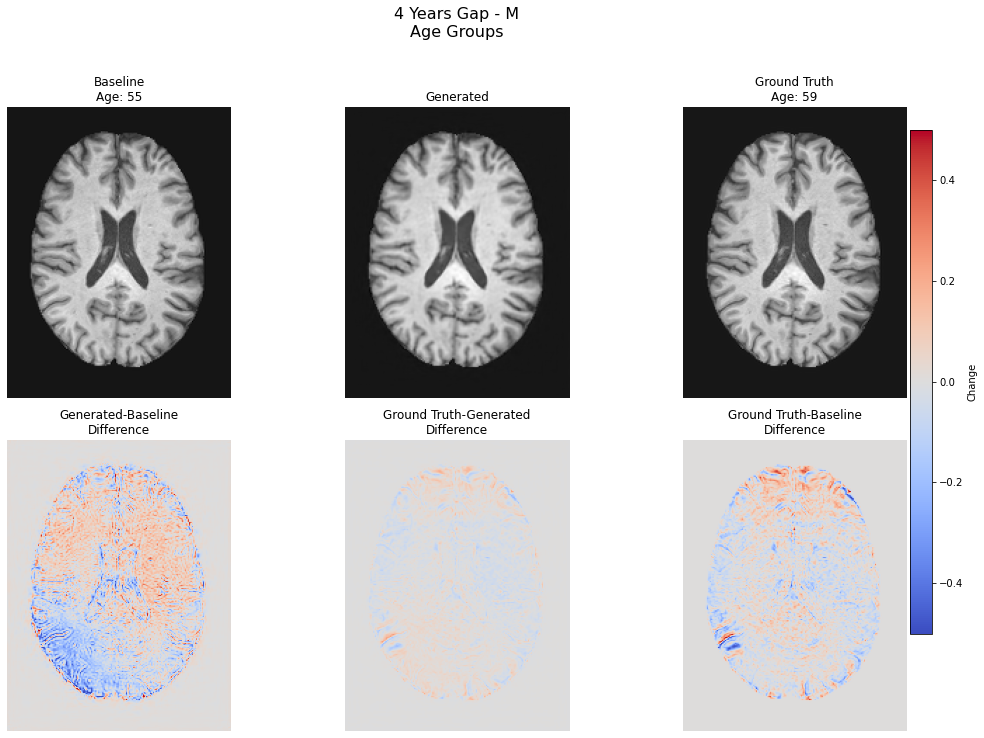

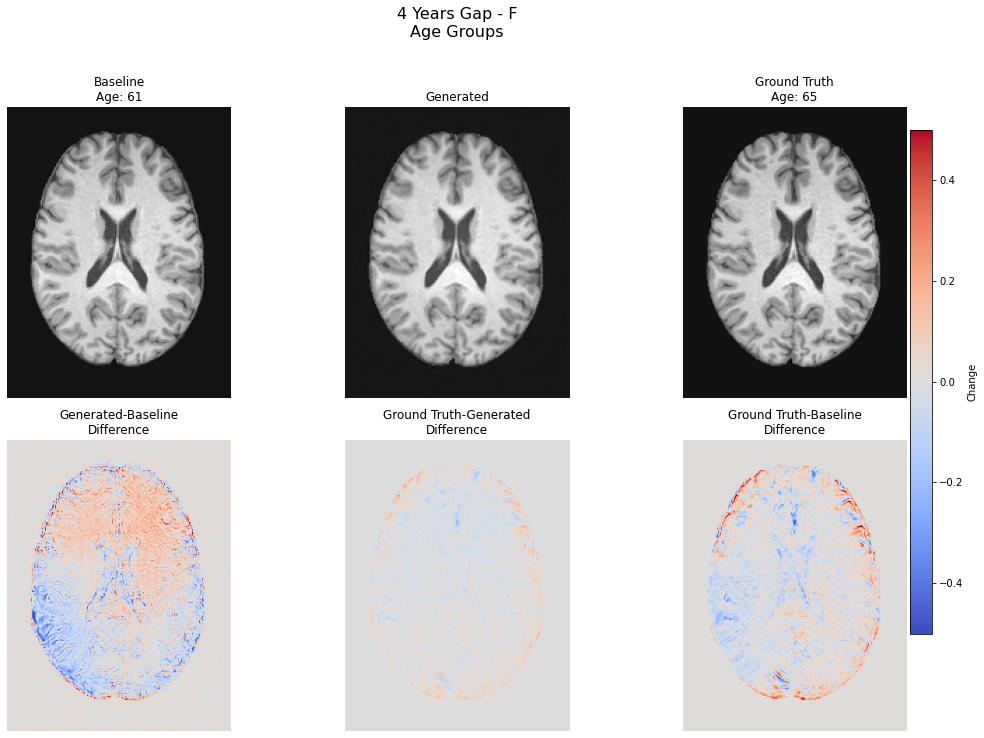

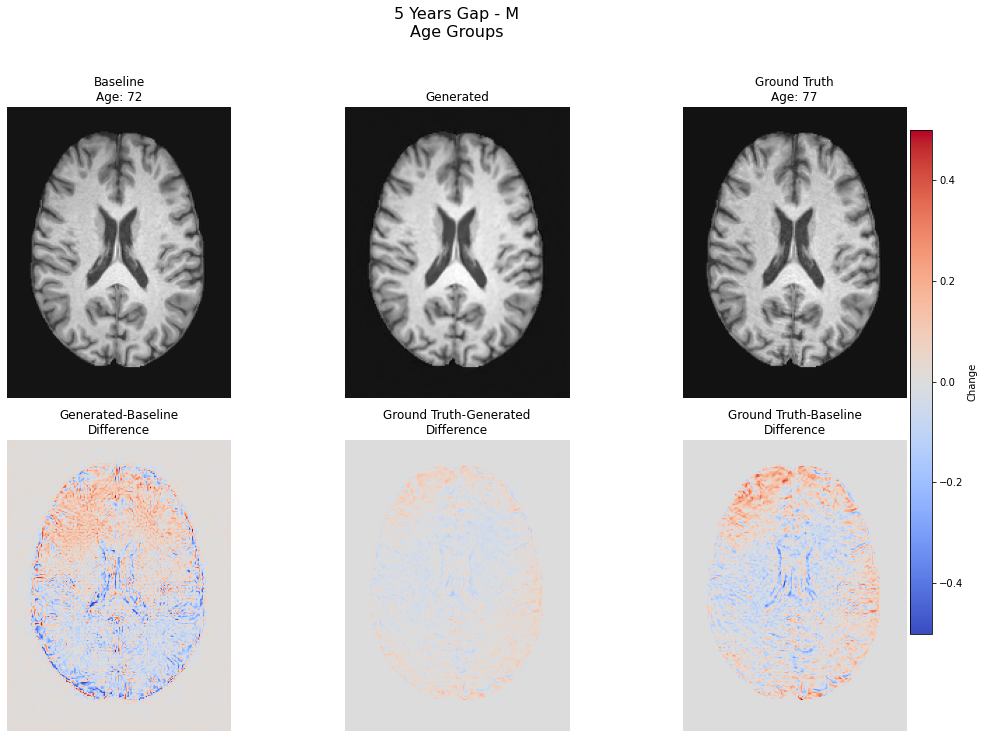

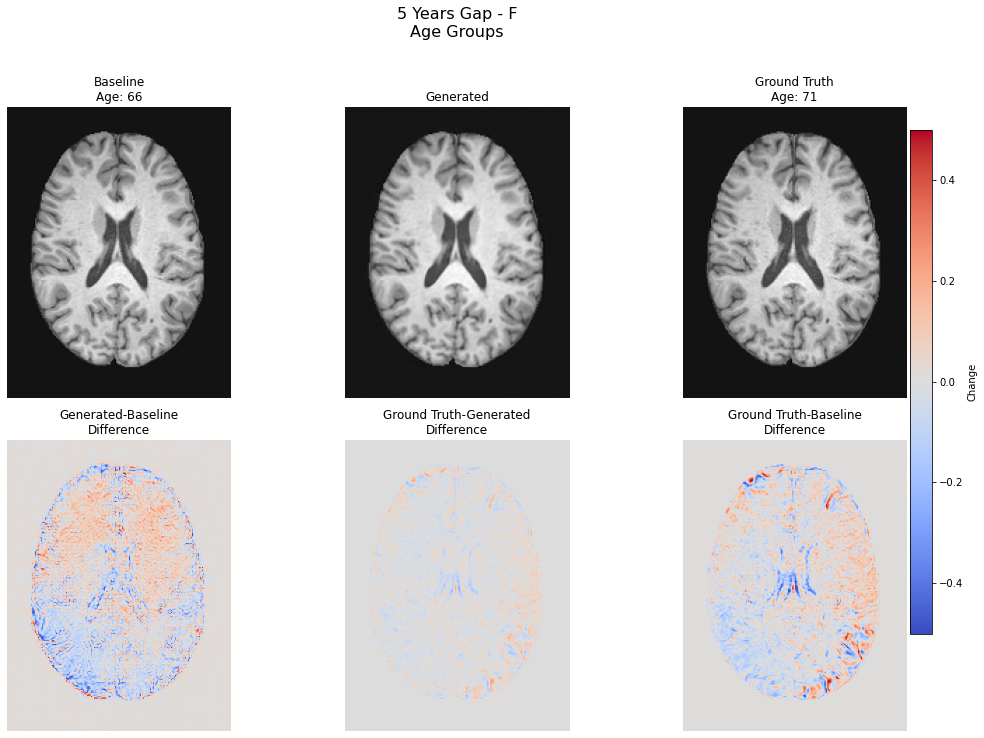

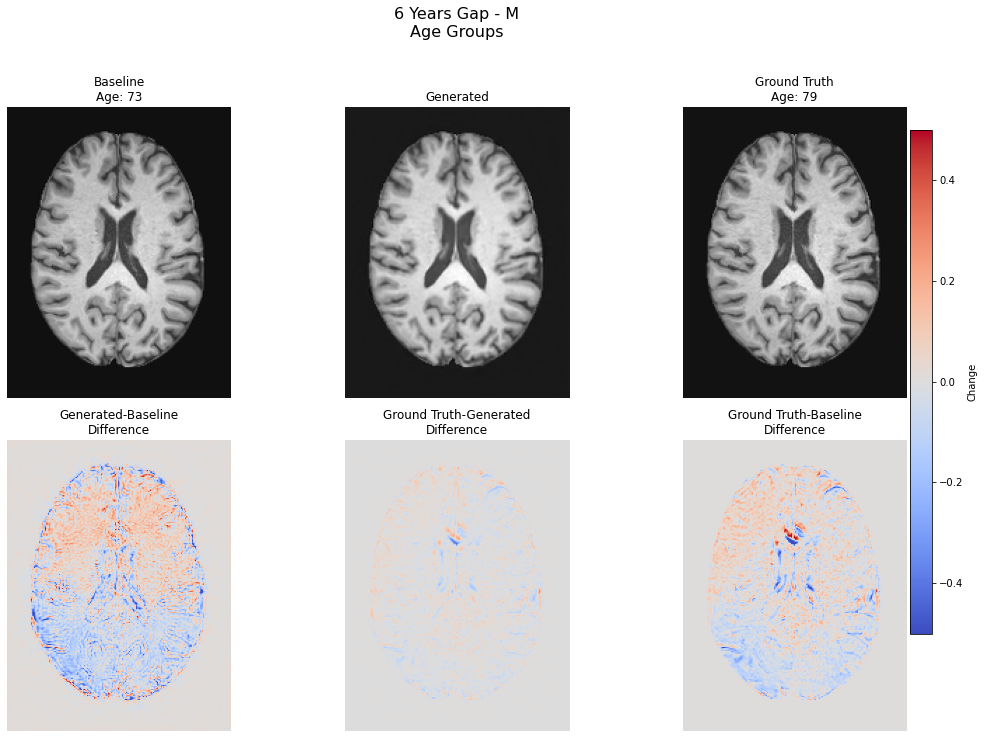

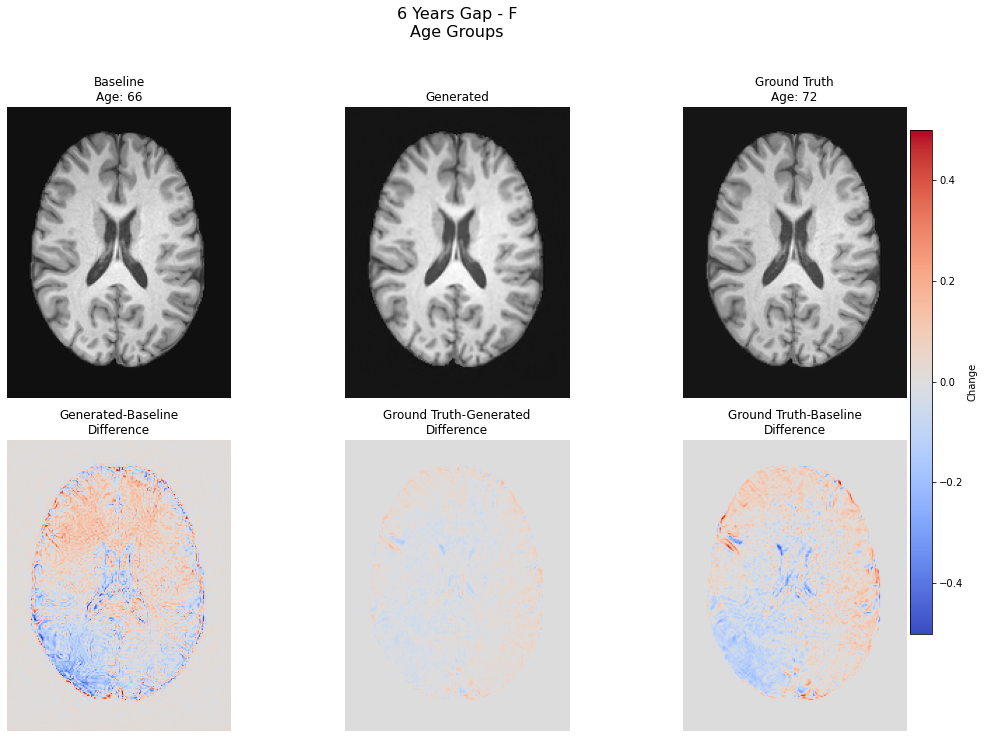

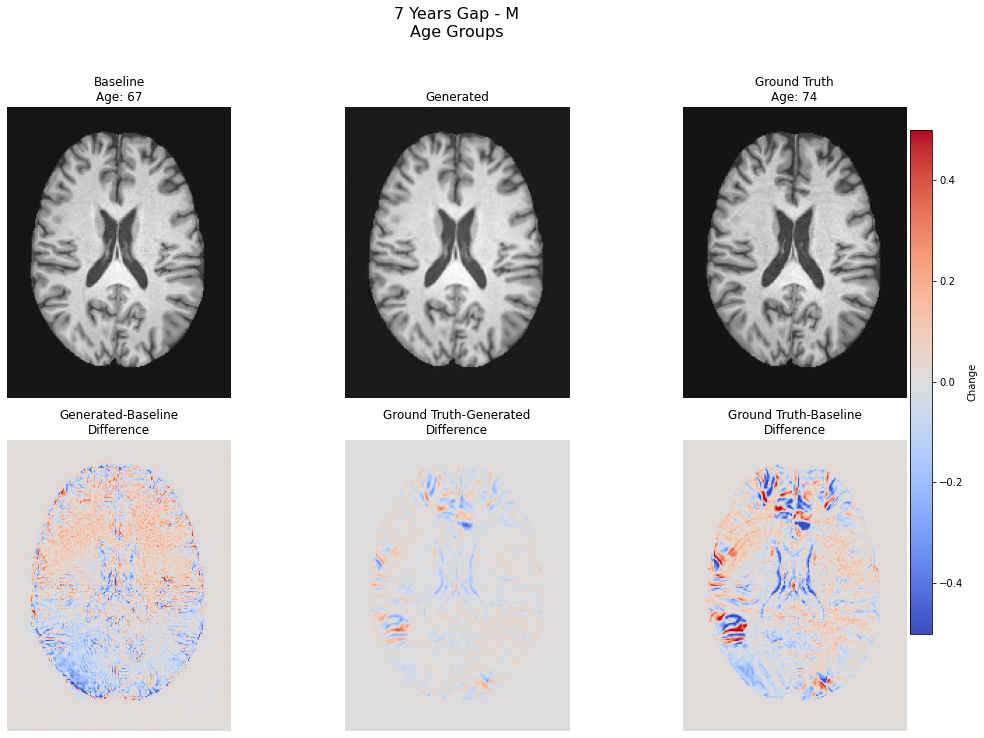

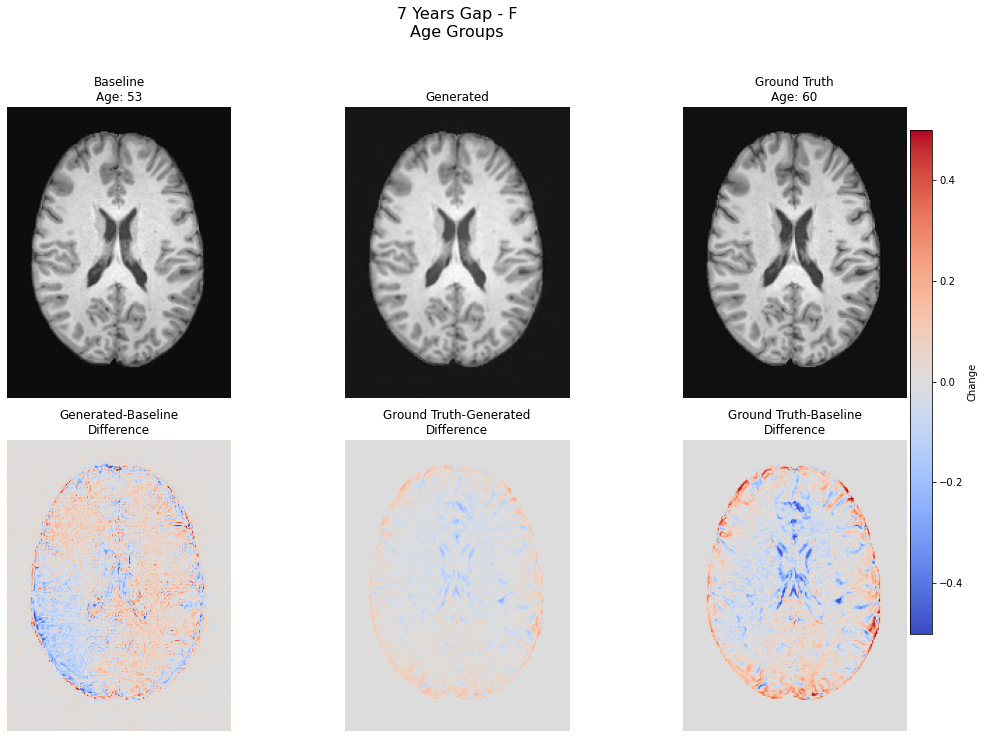

In [14]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def find_age_group_cases(generator, test_loader, device):
    """각 age gap, 성별, 연령대별 케이스 찾기"""
    age_groups = {40: (40, 49), 50: (50, 59), 60: (60, 69), 70: (70, 79), 80: (80, 89)}
    
    cases = {gap: {'M': {age: None for age in age_groups.keys()},
                   'F': {age: None for age in age_groups.keys()}}
             for gap in range(4, 8)}
    
    generator.eval()
    with torch.no_grad():
        for t0_image, t1_image, conditions, age_gap in test_loader:
            long_term_mask = age_gap.squeeze() >= 4
            if not long_term_mask.any():
                continue
            
            t0_image = t0_image[long_term_mask].to(device)
            t1_image = t1_image[long_term_mask].to(device)
            conditions = conditions[long_term_mask].to(device)
            age_gap = age_gap[long_term_mask].to(device)
            
            z = torch.randn(t0_image.size(0), 100, device=device)
            generated_images = generator(t0_image, z, conditions, age_gap)
            
            for idx in range(len(t0_image)):
                current_gap = int(age_gap[idx].item())
                if current_gap > 7:
                    continue
                    
                sex = 'F' if conditions[idx, 1].item() == 0 else 'M'
                current_age = conditions[idx, 0].item()
                
                for age_group in age_groups.keys():
                    min_age, max_age = age_groups[age_group]
                    if min_age <= current_age < max_age:
                        diff_map = (generated_images[idx] - t0_image[idx]).cpu().numpy()[0]
                        orig_target_diff = (t1_image[idx] - t0_image[idx]).cpu().numpy()[0]
                        
                        if (cases[current_gap][sex][age_group] is None or 
                            np.mean(np.abs(diff_map)) > np.mean(np.abs(cases[current_gap][sex][age_group]['diff_map']))):
                            cases[current_gap][sex][age_group] = {
                                'baseline': t0_image[idx],
                                'ground_truth': t1_image[idx],
                                'generated': generated_images[idx],
                                'diff_map': diff_map,
                                'orig_target_diff': orig_target_diff,
                                'current_age': current_age,
                                'age_gap': current_gap
                            }
                        break
    return cases

def visualize_age_group_cases(cases):
    """연령대별 케이스 시각화"""
    for gap in range(4, 8):
        for sex in ['M', 'F']:
            valid_ages = []
            for age_group in range(40, 90, 10):
                if cases[gap][sex][age_group] is not None:
                    valid_ages.append(age_group)
            
            if not valid_ages:
                continue
            
            fig, axs = plt.subplots(2, 3, figsize=(15, 10))
            fig.suptitle(f'{gap} Years Gap - {sex}\nAge Groups', fontsize=16, y=1.02)
            
            for age_group in valid_ages:
                data = cases[gap][sex][age_group]
                
                axs[0, 0].imshow(rotate(data['baseline'].cpu().numpy()[0], 90), cmap='gray')
                axs[0, 0].set_title(f'Baseline\nAge: {data["current_age"]:.0f}')
                axs[0, 0].axis('off')
                
                axs[0, 1].imshow(rotate(data['generated'].cpu().numpy()[0], 90), cmap='gray')
                axs[0, 1].set_title('Generated')
                axs[0, 1].axis('off')
                
                axs[0, 2].imshow(rotate(data['ground_truth'].cpu().numpy()[0], 90), cmap='gray')
                axs[0, 2].set_title(f'Ground Truth\nAge: {data["current_age"] + data["age_gap"]:.0f}')
                axs[0, 2].axis('off')
                
                gen_diff = np.clip(rotate(data['diff_map'], 90) * 5.0, -0.5, 0.5)
                axs[1, 0].imshow(gen_diff, cmap='coolwarm', vmin=-0.5, vmax=0.5)
                axs[1, 0].set_title('Generated-Baseline\nDifference')
                axs[1, 0].axis('off')
                
                # Here is the modification: Ground Truth - Generated
                gt_gen_diff = np.clip(rotate(data['orig_target_diff'] - data['diff_map'], 90) * 0.8, -0.5, 0.5)
                axs[1, 1].imshow(gt_gen_diff, cmap='coolwarm', vmin=-0.5, vmax=0.5)
                axs[1, 1].set_title('Ground Truth-Generated\nDifference')
                axs[1, 1].axis('off')
                
                gt_baseline_diff = np.clip(rotate(data['orig_target_diff'], 90) * 2.0, -0.5, 0.5)
                axs[1, 2].imshow(gt_baseline_diff, cmap='coolwarm', vmin=-0.5, vmax=0.5)
                axs[1, 2].set_title('Ground Truth-Baseline\nDifference')
                axs[1, 2].axis('off')
            
            fig.tight_layout()
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            fig.colorbar(axs[1, 2].images[0], cax=cbar_ax, label='Change')
            plt.show()


# 실행
cases = find_age_group_cases(generator, test_dataloader, device)
visualize_age_group_cases(cases)


<span style="font-size: 20px;">**mNCC**</span>

In [15]:
def calculate_mncc(diff_map1, diff_map2):
    """Mean Normalized Cross Correlation 계산"""
    if isinstance(diff_map1, torch.Tensor):
        diff_map1 = diff_map1.cpu().numpy()
    if isinstance(diff_map2, torch.Tensor):
        diff_map2 = diff_map2.cpu().numpy()
        
    norm_diff1 = (diff_map1 - diff_map1.mean()) / (diff_map1.std() + 1e-6)
    norm_diff2 = (diff_map2 - diff_map2.mean()) / (diff_map2.std() + 1e-6)
    
    return np.mean(norm_diff1 * norm_diff2)


def evaluate_mncc(cases):
    """논문의 방식대로 mNCC 평가"""
    gen_mnccs, random_mnccs = [], []
    all_real_diffs = [cases[gap][sex][age_group]['orig_target_diff']
                      for gap in range(4, 8)
                      for sex in ['M', 'F']
                      for age_group in range(40, 90, 10)
                      if cases[gap][sex][age_group] is not None]
    
    for gap in range(4, 8):
        for sex in ['M', 'F']:
            for age_group in range(40, 90, 10):
                if cases[gap][sex][age_group] is None:
                    continue
                    
                data = cases[gap][sex][age_group]
                gen_mnccs.append(calculate_mncc(data['orig_target_diff'], data['diff_map']))
    
    for _ in range(len(gen_mnccs)):
        idx1, idx2 = np.random.choice(len(all_real_diffs), size=2, replace=False)
        random_mnccs.append(calculate_mncc(all_real_diffs[idx1], all_real_diffs[idx2]))
    
    return np.mean(gen_mnccs), np.std(gen_mnccs), np.mean(random_mnccs), np.std(random_mnccs)

# 실행

gen_mean, gen_std, random_mean, random_std = evaluate_mncc(cases)

print(f"Generated vs Real mNCC: {gen_mean:.3f} ± {gen_std:.3f}")
print(f"Random Real vs Real mNCC: {random_mean:.3f} ± {random_std:.3f}")


Generated vs Real mNCC: 0.346 ± 0.053
Random Real vs Real mNCC: 0.110 ± 0.082
